# 客戶區隔(Customer segmentation)

## 載入相關套件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 載入資料集

In [3]:
df = pd.read_csv("./data/invoice.csv", encoding="ISO-8859-1")
# 只分析英國的顧客
df = df[df.Country == "United Kingdom"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 描述統計量

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,495478.0,8.605486,227.588756,-80995.00,1.00,3.0,10.00,80995.0
UnitPrice,495478.0,4.532422,99.315438,-11062.06,1.25,2.1,4.13,38970.0
CustomerID,361878.0,15547.871368,1594.402590,12346.00,14194.00,15514.0,16931.00,18287.0


## 資料清理

## 移除非購買記錄

In [5]:
# 移除數量<=0的交易記錄
df = df[df["Quantity"] > 0]

# 移除單價<=0的交易記錄
df = df[df["UnitPrice"] > 0]
print(df.Quantity.describe())
df.UnitPrice.describe()

count    485123.000000
mean          9.610738
std         161.904143
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64


count    485123.000000
mean          3.849679
std          34.677371
min           0.001000
25%           1.250000
50%           2.100000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

## 刪除 Missing Value

In [6]:
df.dropna(subset=["CustomerID"], inplace=True)

# 檢查 Missing Value
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 找出資料集的最近購買日期

In [7]:
# 找出資料集的最近購買日期
print(df["InvoiceDate"].max())

# 日期轉 YYYY-MM-DD
df["date"] = pd.DatetimeIndex(df.InvoiceDate).date

9/9/2011 9:52


## 計算 Recency

In [8]:
# 計算每個顧客的最近購買日期
recency_df = df.groupby(["CustomerID"], as_index=False)["date"].max()
recency_df.columns = ["CustomerID", "LastPurchaseDate"]

# 計算每個顧客的上次消費的日期距今天數
now = df["date"].max()
recency_df["Recency"] = recency_df.LastPurchaseDate.apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [9]:
recency_df.drop(columns=["LastPurchaseDate"], inplace=True)

## 計算 Frequency

In [10]:
# 計算每個顧客的消費次數
frequency_df = df.copy()
frequency_df.drop_duplicates(
    subset=["CustomerID", "InvoiceNo"], keep="first", inplace=True
)
frequency_df = frequency_df.groupby("CustomerID", as_index=False)["InvoiceNo"].count()
frequency_df.columns = ["CustomerID", "Frequency"]
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,209
3,12749.0,5
4,12820.0,4


## 計算 Monetary

In [11]:
# 計算每個顧客的累計消費金額
df["Total_cost"] = df["UnitPrice"] * df["Quantity"]
monetary_df = df.groupby("CustomerID", as_index=False)["Total_cost"].sum()
monetary_df.columns = ["CustomerID", "Monetary"]
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33719.73
3,12749.0,4090.88
4,12820.0,942.34


## 合併 RFM

In [12]:
rf = recency_df.merge(frequency_df, left_on="CustomerID", right_on="CustomerID")
rfm = rf.merge(monetary_df, left_on="CustomerID", right_on="CustomerID")
rfm.set_index("CustomerID", inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,4196.01
12748.0,0,209,33719.73
12749.0,3,5,4090.88
12820.0,3,4,942.34


## 驗算

In [13]:
df[df.CustomerID == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,Total_cost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [14]:
import datetime as dt

now = dt.date(2011, 12, 9)
(now - dt.date(2011, 1, 18)).days == 325

True

## 使用K-Means進行集群

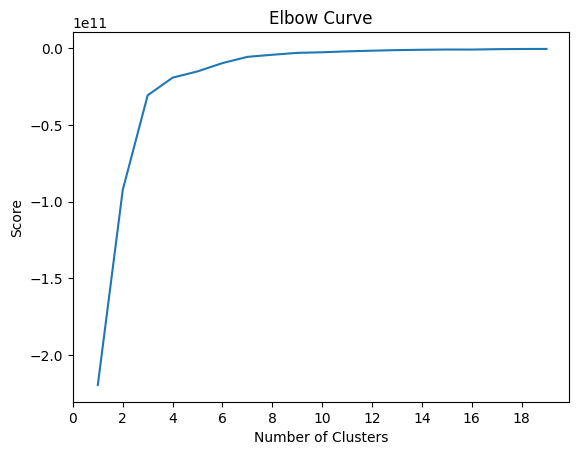

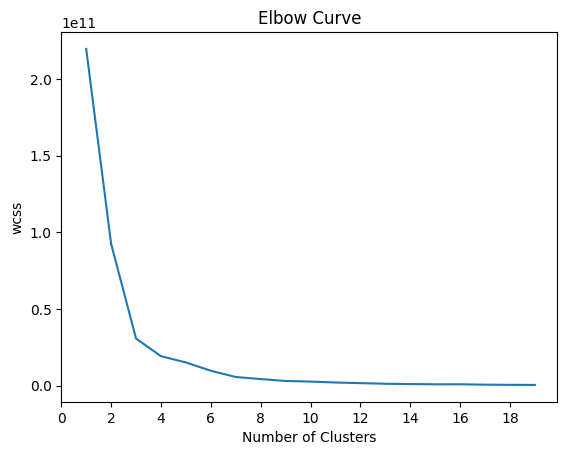

In [15]:
from sklearn.cluster import KMeans

# 複製資料
rfm_segmentation = rfm.copy()

# 轉折判斷法
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i, init="k-means++", n_init="auto") for i in Nc]
for i in range(len(kmeans)):
    kmeans[i].fit(rfm_segmentation)
score = [kmeans[i].score(rfm_segmentation) for i in range(len(kmeans))]
wcss = [kmeans[i].inertia_ for i in range(len(kmeans))]

plt.plot(Nc, score)
plt.xticks(range(0, 20, 2))
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show()

plt.plot(Nc, wcss)
plt.xticks(range(0, 20, 2))
plt.xlabel("Number of Clusters")
plt.ylabel("wcss")
plt.title("Elbow Curve")
plt.show()

## 分成3群

In [16]:
X = rfm_segmentation.copy()
kmeans = KMeans(
    n_clusters=3, init="k-means++", n_init=10, max_iter=300, random_state=0
).fit(X)

# 新增欄位，加入集群代碼
rfm_segmentation["cluster"] = kmeans.labels_

# 觀看集群 0 的前 10 筆資料
rfm_segmentation[rfm_segmentation.cluster == 0].head(10)

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12747.0,2,11,4196.01,0
12749.0,3,5,4090.88,0
12820.0,3,4,942.34,0
12821.0,214,1,92.72,0
12822.0,70,2,948.88,0
12823.0,74,5,1759.50,0
12824.0,59,1,397.12,0
12826.0,2,7,1474.72,0
12827.0,5,3,430.15,0


## 計算每群筆數

In [17]:
rfm_segmentation["cluster"].value_counts()

cluster
0    3887
2      30
1       3
Name: count, dtype: int64

## 輪廓係數

In [18]:
from sklearn.metrics import silhouette_samples

y_km = rfm_segmentation["cluster"]
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric="euclidean")
silhouette_vals

array([0.5703689 , 0.92298215, 0.48457003, ..., 0.97354136, 0.96318191,
       0.96694445])

## 繪製輪廓圖

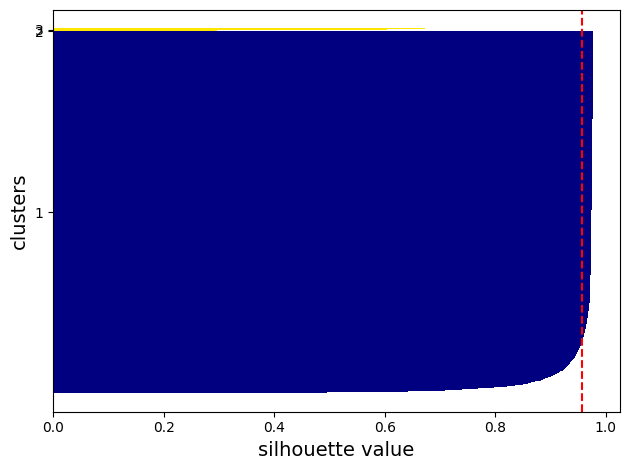

In [19]:
from matplotlib import cm

# 輪廓圖
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(
        range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor="none",
        color=color,
    )

    yticks.append((y_ax_lower + y_ax_upper) / 2.0)
    y_ax_lower += len(c_silhouette_vals)

# 輪廓係數平均數的垂直線
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("clusters", fontsize=14)
plt.xlabel("silhouette value", fontsize=14)
plt.tight_layout();

## 依據輪廓分數找最佳集群數量

In [20]:
# 測試 2~20 群的分數
from sklearn.metrics import silhouette_score

silhouette_score_list = []
print("輪廓分數:")
for i in range(2, 21):
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    y_km = km.fit_predict(X)
    silhouette_score_list.append(silhouette_score(X, y_km))
    print(f"{i}:{silhouette_score_list[-1]:.2f}")

print(
    f"最大值 {np.argmax(silhouette_score_list)+2}: {np.max(silhouette_score_list):.2f}"
)

輪廓分數:
2:0.97
3:0.96
4:0.84
5:0.81
6:0.81
7:0.73
8:0.73
9:0.68
10:0.64
11:0.64
12:0.61
13:0.62
14:0.57
15:0.59
16:0.57
17:0.56
18:0.56
19:0.52
20:0.53
最大值 2: 0.97


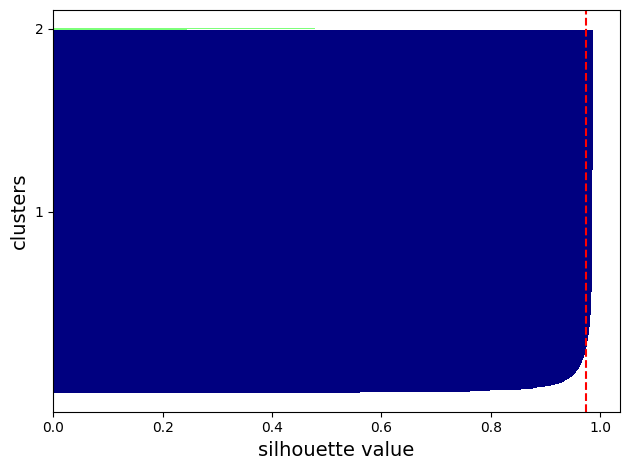

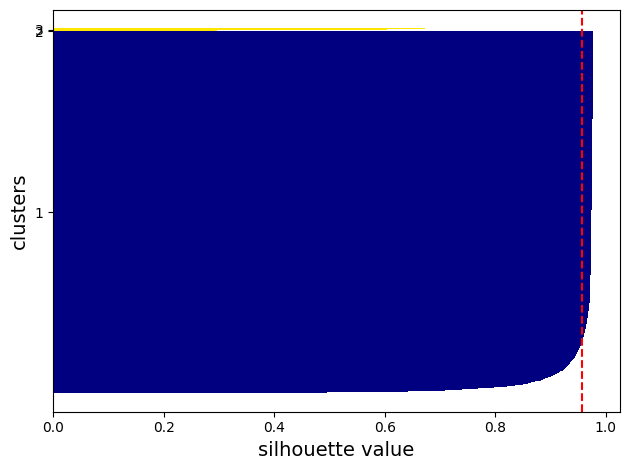

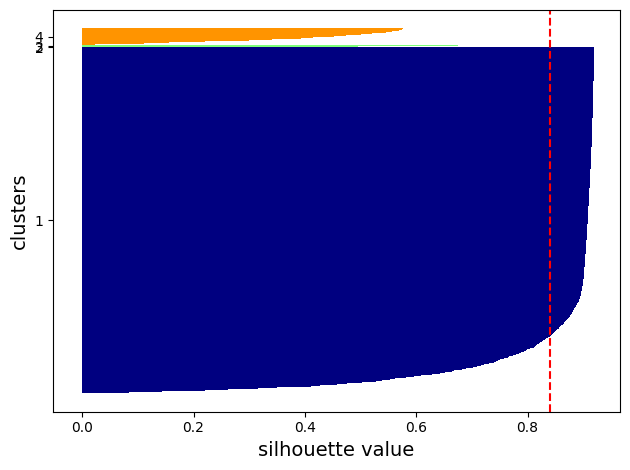

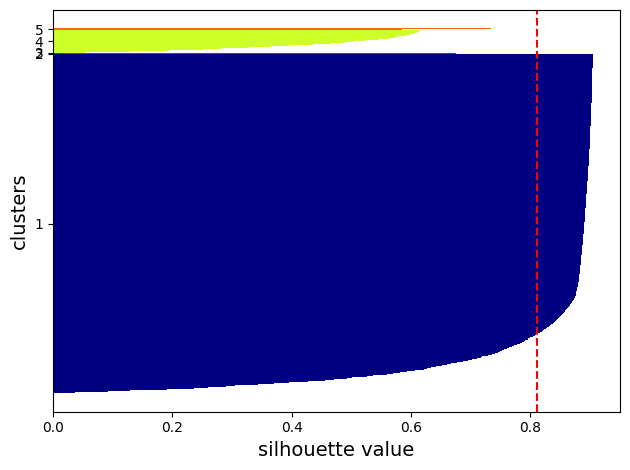

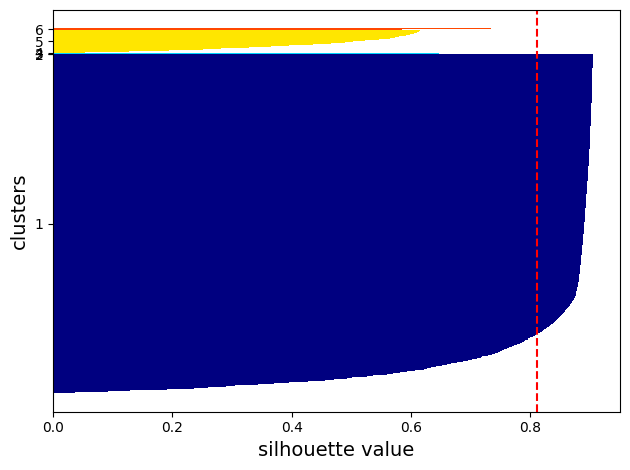

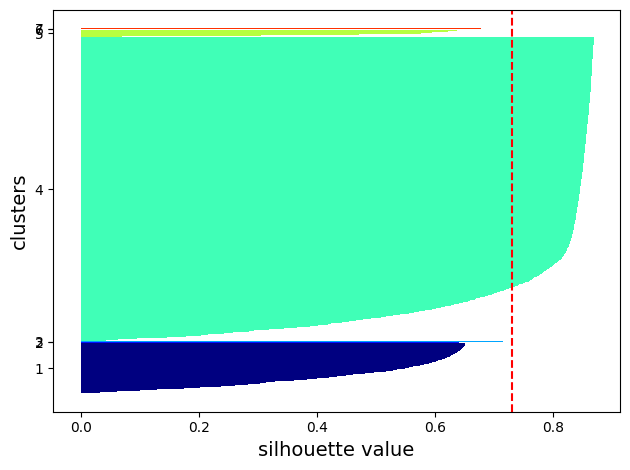

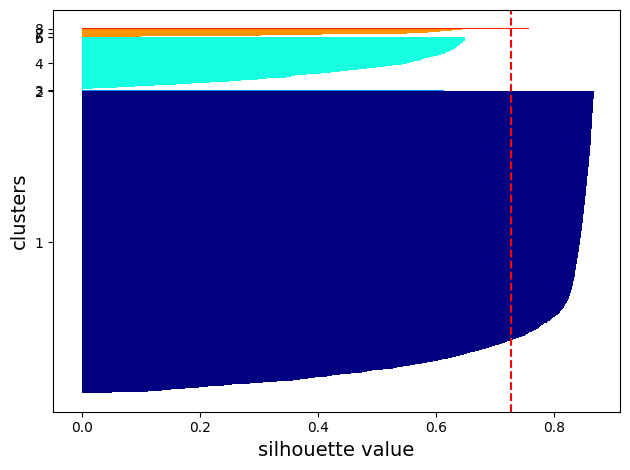

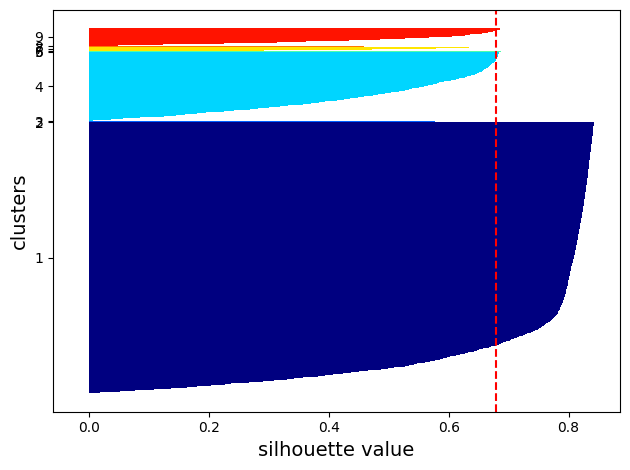

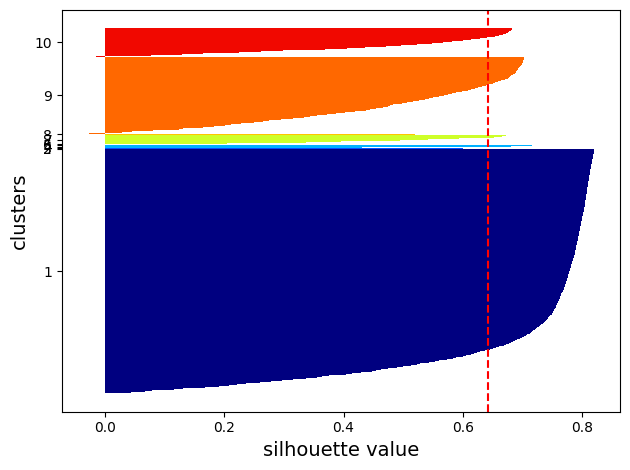

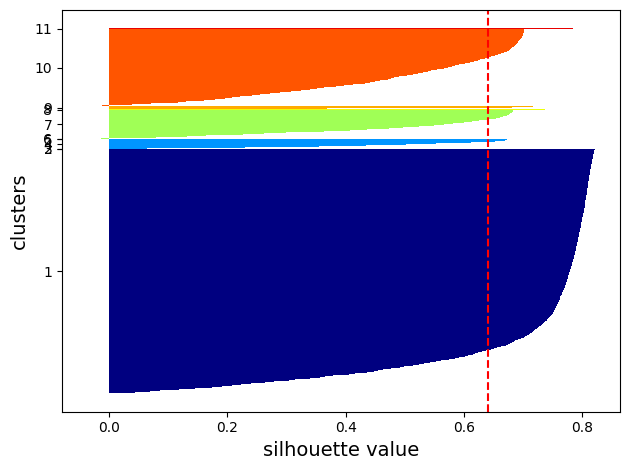

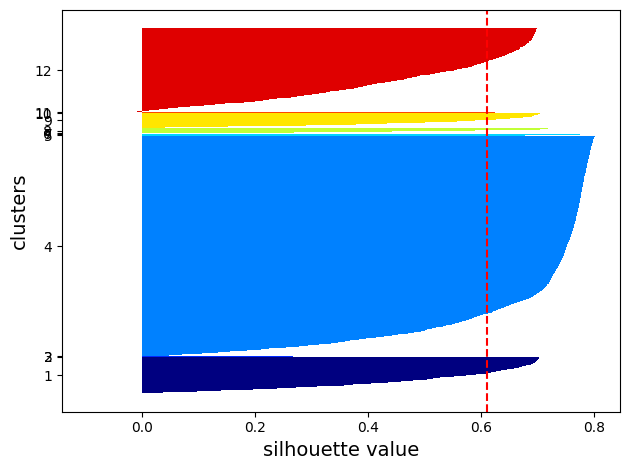

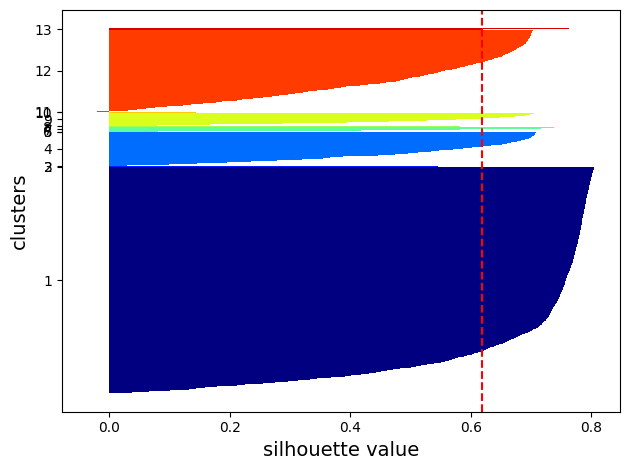

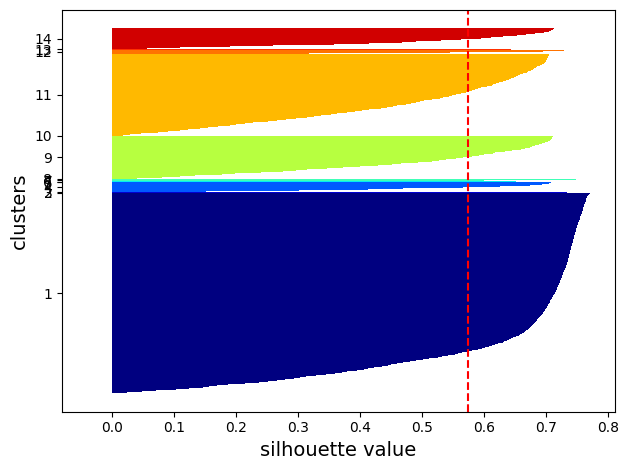

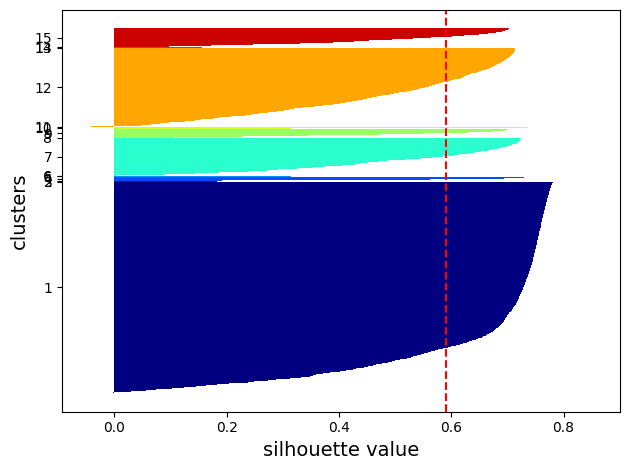

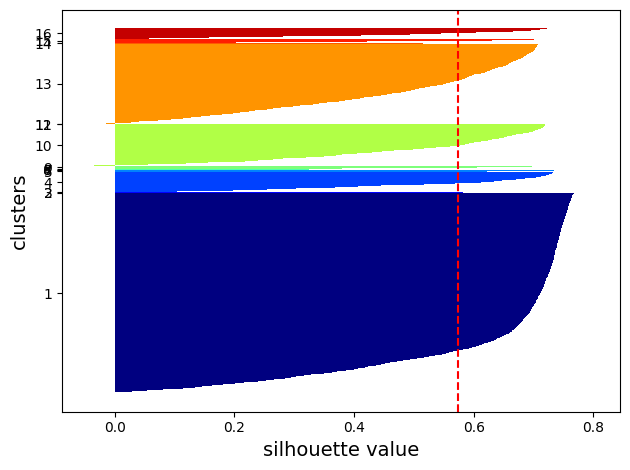

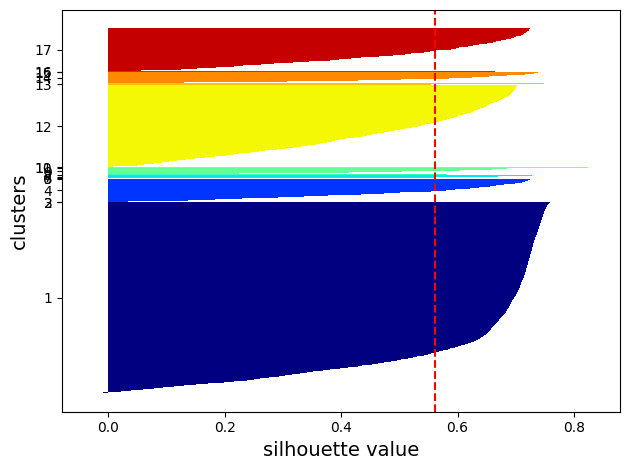

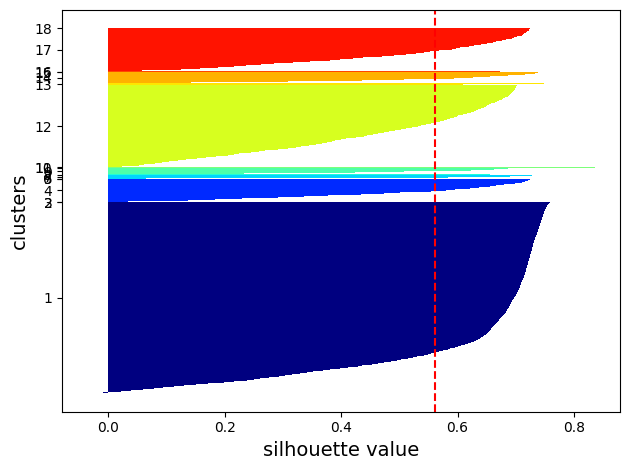

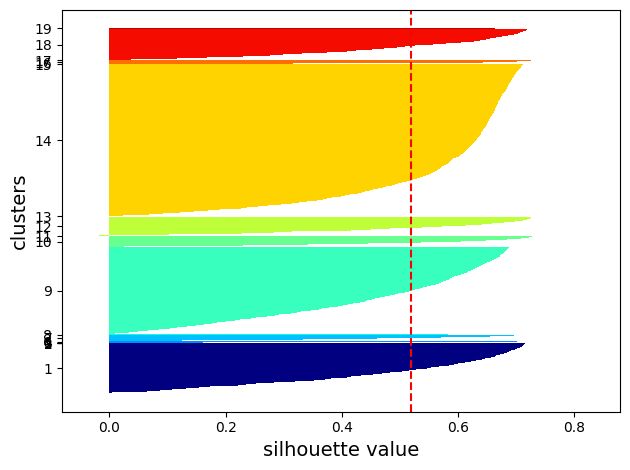

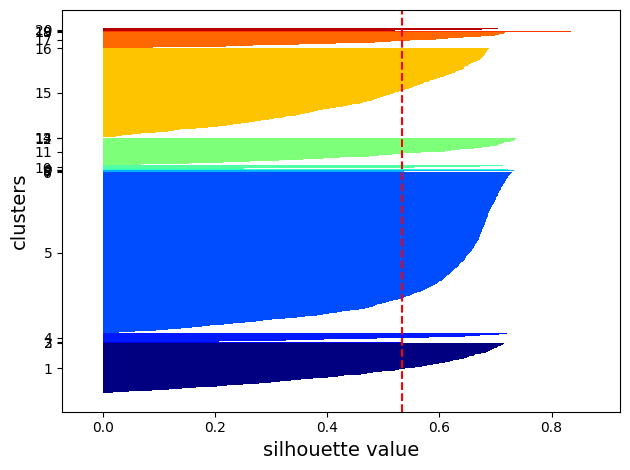

In [21]:
for i in range(2, 21):
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0
    ).fit(X)

    # 新增欄位，加入集群代碼
    y_km = km.labels_
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric="euclidean")

    # 輪廓圖
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
        )

        yticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(c_silhouette_vals)

    # 輪廓係數平均數的垂直線
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel("clusters", fontsize=14)
    plt.xlabel("silhouette value", fontsize=14)
    plt.tight_layout()
    plt.show()

# RFM 分組

In [22]:
# 四分位數分組
def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1


# 四分位數(quantile)
quantile = rfm.quantile(q=[0.25, 0.5, 0.75])
quantile

,Recency,Frequency,Monetary
0.25,17.0,1.0,300.280
0.50,50.0,2.0,652.280
0.75,142.0,5.0,1576.585


In [23]:
quantile.to_dict()

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 300.28000000000003, 0.5: 652.28, 0.75: 1576.585}}

# RFM依四分位數給分

In [24]:
rfm_segmentation["R_Quartile"] = rfm_segmentation["Recency"].apply(
    RScore, args=("Recency", quantile)
)
rfm_segmentation["F_Quartile"] = rfm_segmentation["Frequency"].apply(
    FMScore, args=("Frequency", quantile)
)
rfm_segmentation["M_Quartile"] = rfm_segmentation["Monetary"].apply(
    FMScore, args=("Monetary", quantile)
)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2,4,4,1
12747.0,2,11,4196.01,0,1,1,1
12748.0,0,209,33719.73,2,1,1,1
12749.0,3,5,4090.88,0,1,2,1
12820.0,3,4,942.34,0,1,2,2


In [25]:
# 合併 RFM 分數
rfm_segmentation["RFMScore"] = (
    rfm_segmentation.R_Quartile.map(str)
    + rfm_segmentation.F_Quartile.map(str)
    + rfm_segmentation.M_Quartile.map(str)
)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2,4,4,1,441
12747.0,2,11,4196.01,0,1,1,1,111
12748.0,0,209,33719.73,2,1,1,1,111
12749.0,3,5,4090.88,0,1,2,1,121
12820.0,3,4,942.34,0,1,2,2,122


In [26]:
# 計算 RFM 總分
rfm_segmentation["Total_score"] = (
    rfm_segmentation["R_Quartile"]
    + rfm_segmentation["F_Quartile"]
    + rfm_segmentation["M_Quartile"]
)

rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,2,4,4,1,441,9
12747.0,2,11,4196.01,0,1,1,1,111,3
12748.0,0,209,33719.73,2,1,1,1,111,3
12749.0,3,5,4090.88,0,1,2,1,121,4
12820.0,3,4,942.34,0,1,2,2,122,5


In [27]:
print("客戶篩選：")
print("Best Customers: ", len(rfm_segmentation[rfm_segmentation["RFMScore"] == "111"]))
print("Loyal Customers: ", len(rfm_segmentation[rfm_segmentation["F_Quartile"] == 1]))
print("Big Spenders: ", len(rfm_segmentation[rfm_segmentation["M_Quartile"] == 1]))
print("Almost Lost: ", len(rfm_segmentation[rfm_segmentation["RFMScore"] == "134"]))
print("Lost Customers: ", len(rfm_segmentation[rfm_segmentation["RFMScore"] == "344"]))
print(
    "Lost Cheap Customers: ",
    len(rfm_segmentation[rfm_segmentation["RFMScore"] == "444"]),
)

客戶篩選：
Best Customers:  423
Loyal Customers:  791
Big Spenders:  980
Almost Lost:  31
Lost Customers:  187
Lost Cheap Customers:  396


In [28]:
# 依分數顯示客戶名單
rfm_segmentation.sort_values(by=["RFMScore", "Monetary"], ascending=[True, False]).head(
    10
)

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
18102.0,0,60,259657.30,1,1,1,1,111,3
17450.0,8,46,194550.79,1,1,1,1,111,3
17511.0,2,31,91062.38,2,1,1,1,111,3
16684.0,4,28,66653.56,2,1,1,1,111,3
14096.0,4,17,65164.79,2,1,1,1,111,3
13694.0,3,50,65039.62,2,1,1,1,111,3
15311.0,0,91,60767.90,2,1,1,1,111,3
13089.0,2,97,58825.83,2,1,1,1,111,3
17949.0,1,45,58510.48,2,1,1,1,111,3


In [29]:
# 依RFM級數顯示每一組的平均消費金額
rfm_segmentation.groupby("RFMScore")["Monetary"].mean().head(10)

RFMScore
111     8443.319409
112     1241.785577
113      443.086667
114      201.120000
121     2482.559268
122     1046.896730
123      508.042326
124      213.450000
131    43967.947500
132      925.355227
Name: Monetary, dtype: float64

In [30]:
# 依RFM總分顯示每一組的平均消費金額
rfm_segmentation.groupby("Total_score")["Monetary"].mean()

Total_score
3     8443.319409
4     3476.003567
5     2334.664483
6     1396.382037
7     1129.331281
8      695.442278
9      704.139754
10     363.057451
11     280.865560
12     158.611742
Name: Monetary, dtype: float64

<Axes: xlabel='Total_score'>

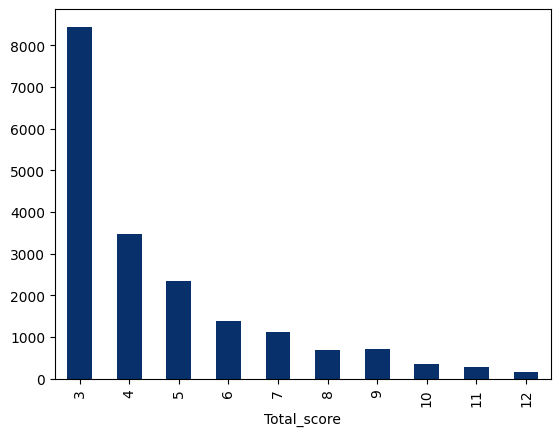

In [31]:
# 依RFM總分作圖，總分 3,4,5 有最高消費金額
rfm_segmentation.groupby("Total_score")["Monetary"].mean().plot(
    kind="bar", colormap="Blues_r"
)

<Axes: xlabel='Total_score'>

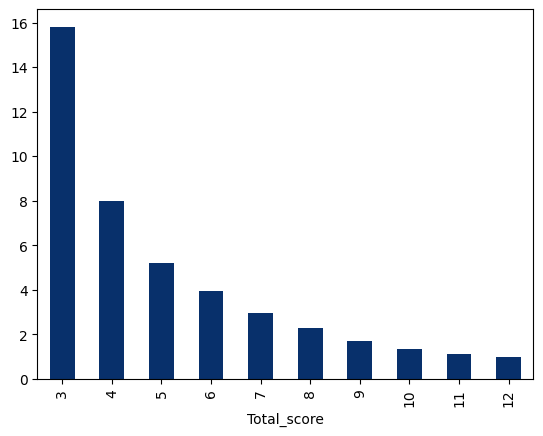

In [32]:
# 依RFM總分作圖，總分 3,4,5 有最高消費次數
rfm_segmentation.groupby("Total_score")["Frequency"].mean().plot(
    kind="bar", colormap="Blues_r"
)

<Axes: xlabel='Total_score'>

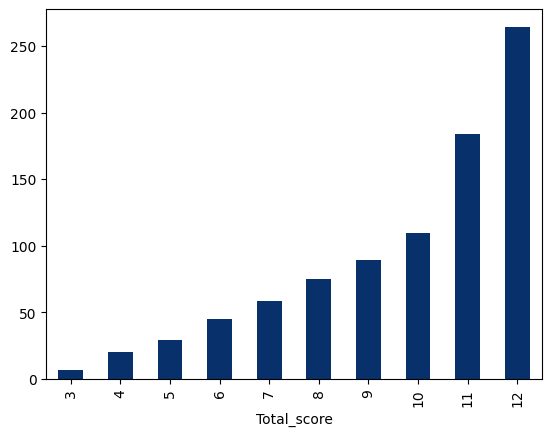

In [33]:
# 依RFM總分作圖，總分 10,11,12 Recency最高
rfm_segmentation.groupby("Total_score")["Recency"].mean().plot(
    kind="bar", colormap="Blues_r"
)

## 依據輪廓分數找最佳集群數量

In [34]:
# 測試 2~20 群的分數
from sklearn.metrics import silhouette_score

X = rfm_segmentation[["R_Quartile", "F_Quartile", "M_Quartile"]]
silhouette_score_list = []
print("輪廓分數:")
for i in range(2, 21):
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    y_km = km.fit_predict(X)
    silhouette_score_list.append(silhouette_score(X, y_km))
    print(f"{i}:{silhouette_score_list[-1]:.2f}")

print(
    f"最大值 {np.argmax(silhouette_score_list)+2}: {np.max(silhouette_score_list):.2f}"
)

輪廓分數:
2:0.47
3:0.42
4:0.42
5:0.43
6:0.41
7:0.43
8:0.42
9:0.45
10:0.46
11:0.47
12:0.51
13:0.51
14:0.54
15:0.56
16:0.57
17:0.61
18:0.62
19:0.63
20:0.66
最大值 20: 0.66


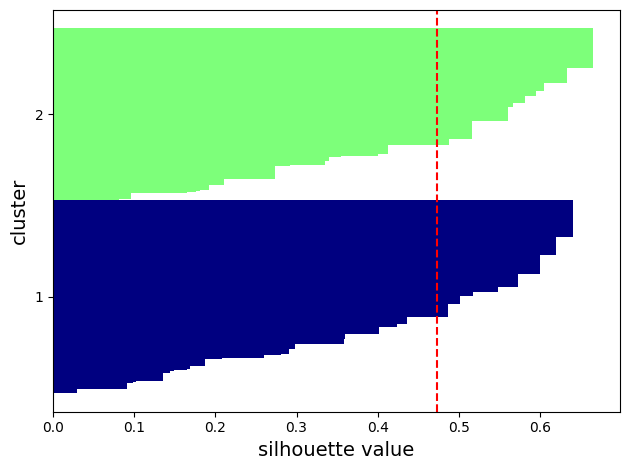

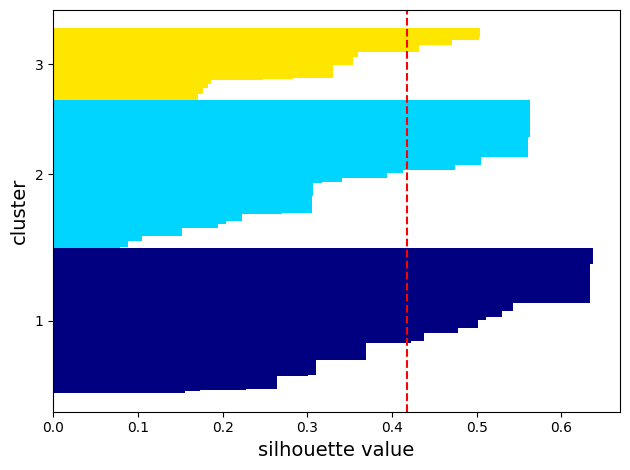

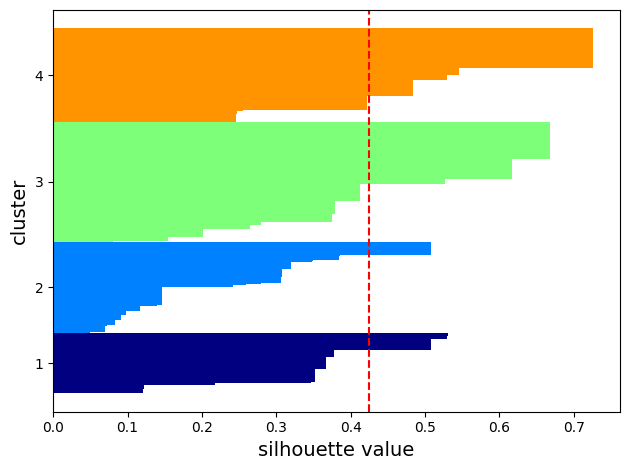

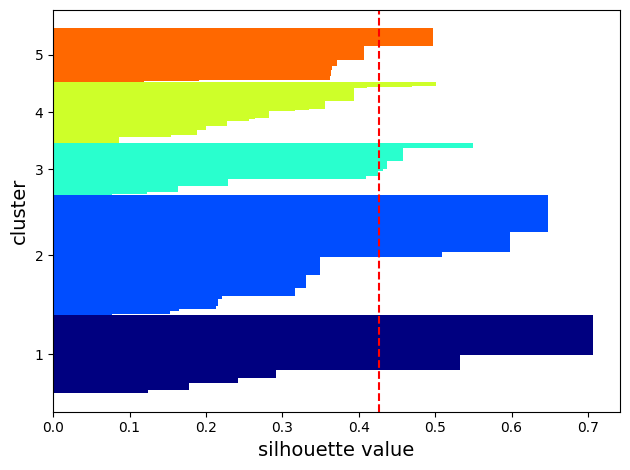

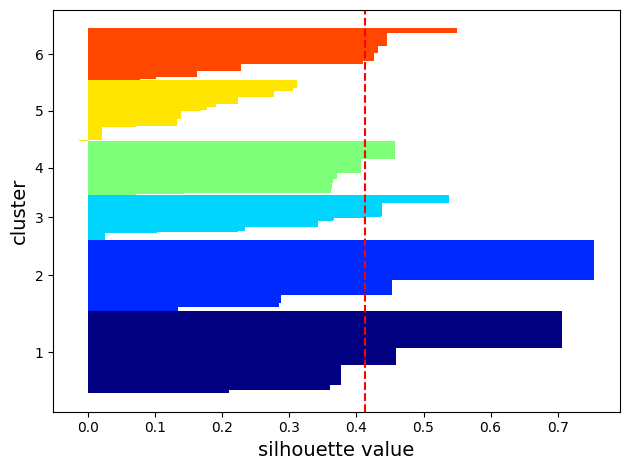

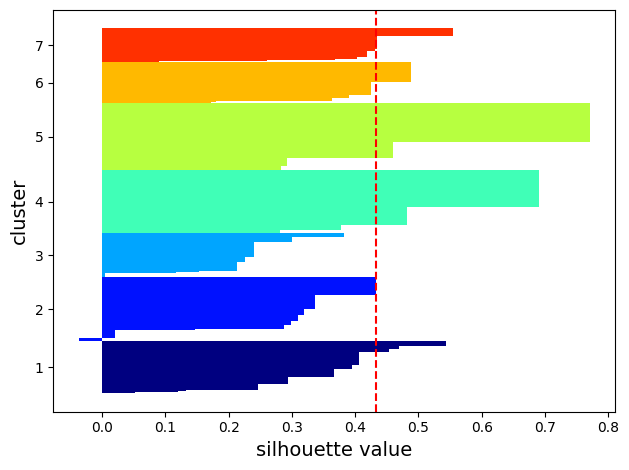

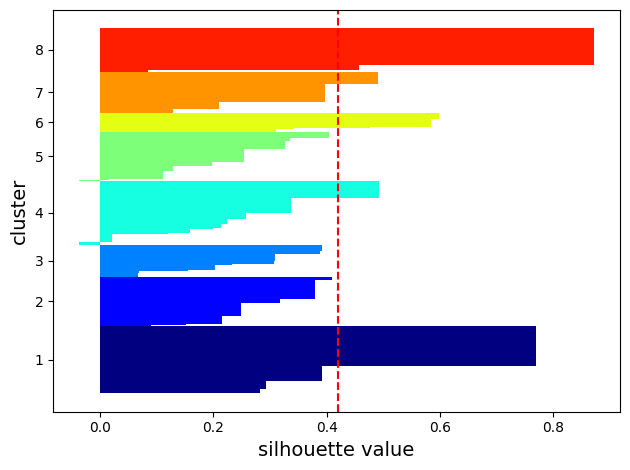

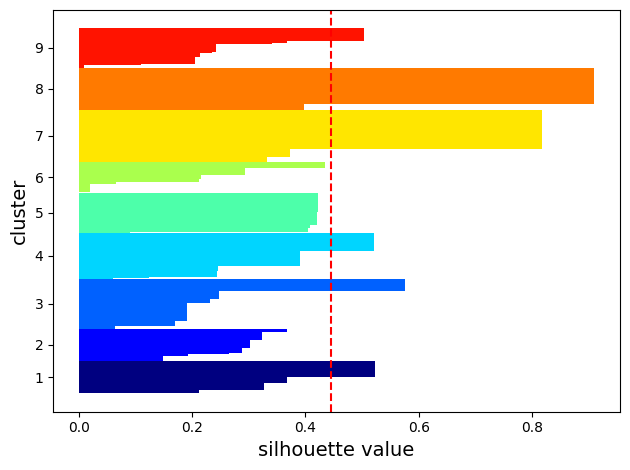

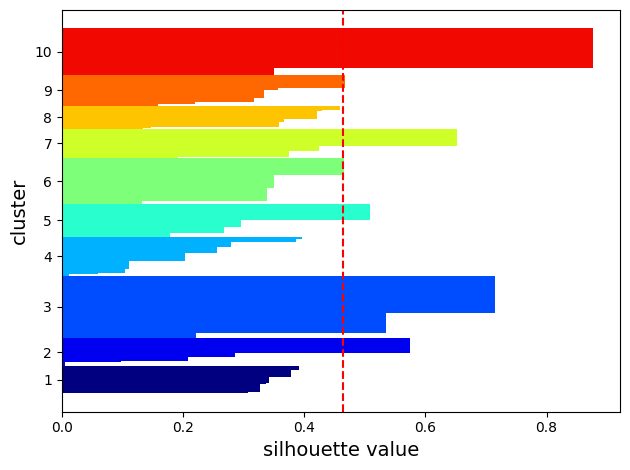

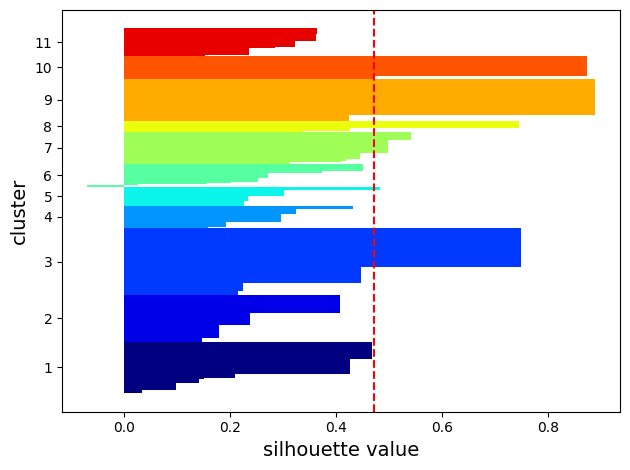

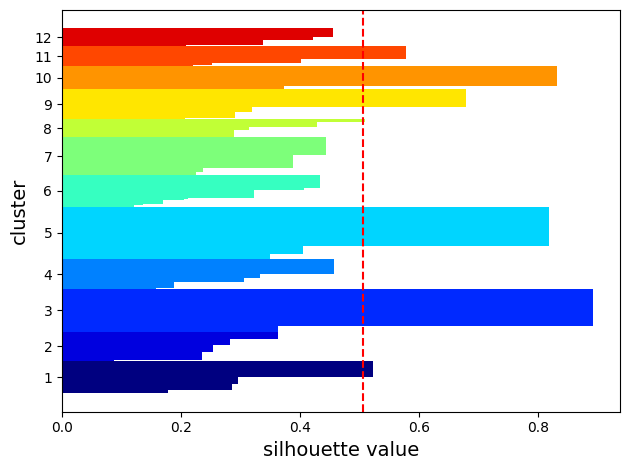

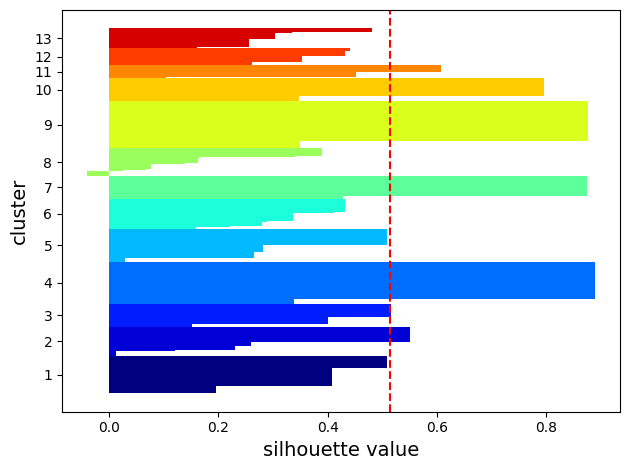

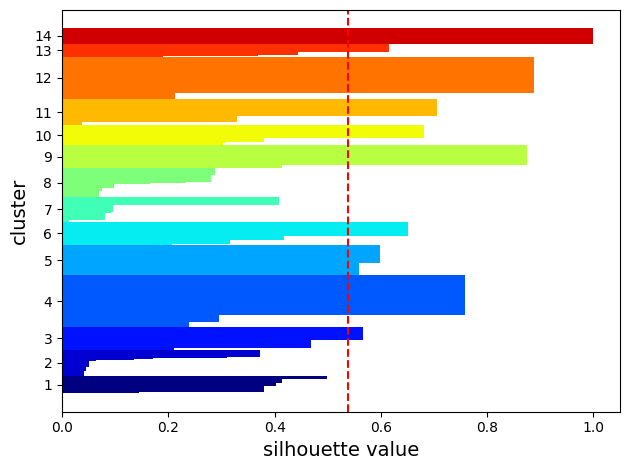

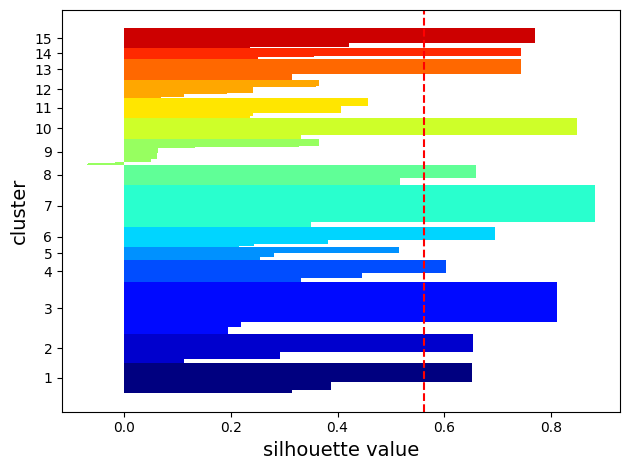

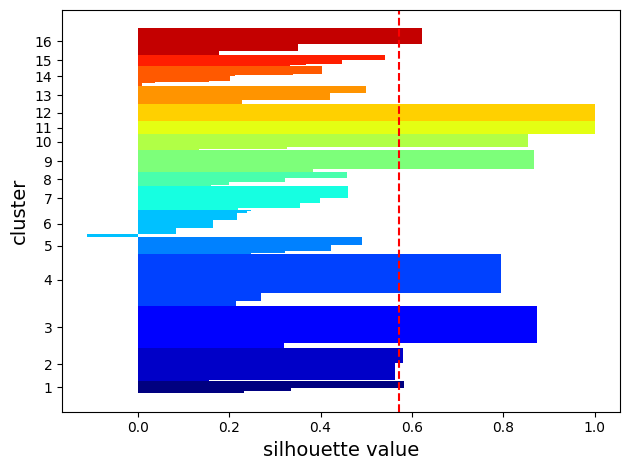

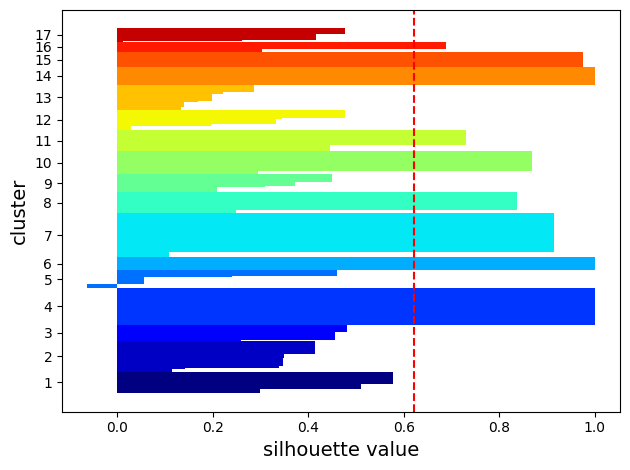

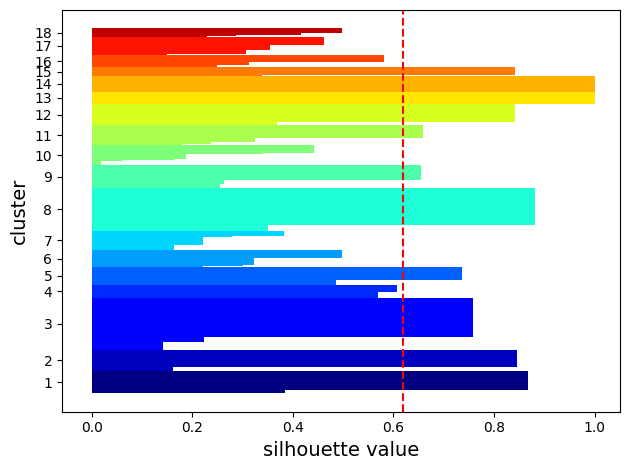

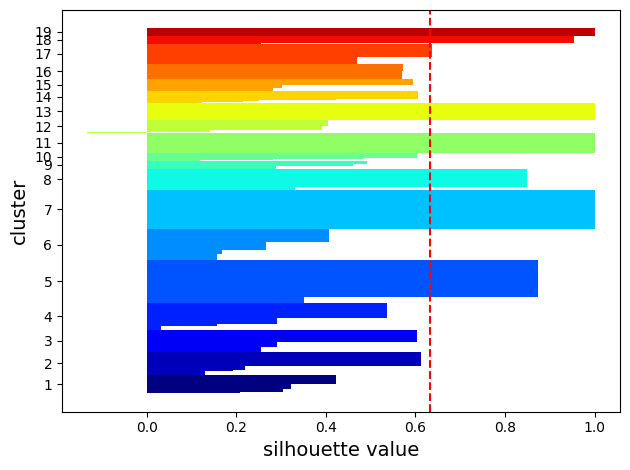

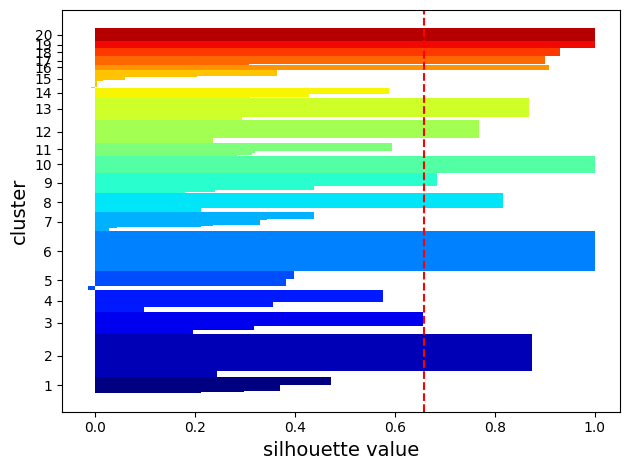

In [35]:
for i in range(2, 21):
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0
    ).fit(X)

    # 新增欄位，加入集群代碼
    y_km = km.labels_
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric="euclidean")

    # 輪廓圖
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
        )

        yticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(c_silhouette_vals)

    # 輪廓係數平均數的垂直線
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel("cluster", fontsize=14)
    plt.xlabel("silhouette value", fontsize=14)
    plt.tight_layout()
    plt.show()

## 分成4個集群

In [36]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

# 新增欄位，加入集群代碼
rfm_segmentation["cluster"] = kmeans.labels_

# 觀看集群 0 的前 10 筆資料
rfm_segmentation[rfm_segmentation.cluster == 0].head(10)

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,0,4,4,1,441,9
12821.0,214,1,92.72,0,4,4,4,444,12
12824.0,59,1,397.12,0,3,4,3,343,10
12829.0,336,2,293.00,0,4,3,4,434,11
12831.0,262,1,215.05,0,4,4,4,444,12
12833.0,145,1,417.38,0,4,4,3,443,11
12834.0,282,1,312.38,0,4,4,3,443,11
12837.0,173,1,134.10,0,4,4,4,444,12
12845.0,267,4,354.09,0,4,2,3,423,9


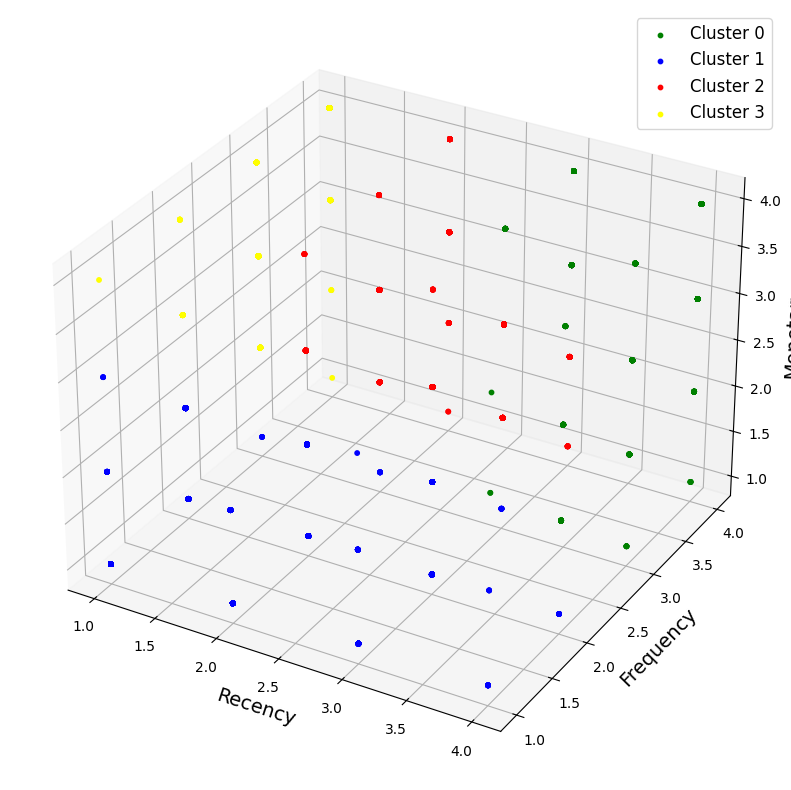

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(12, 8))
dx = fig.add_subplot(111, projection="3d")
colors = ["green", "blue", "red", "yellow"]

for i in range(rfm_segmentation.cluster.nunique()):
    dx.scatter(
        rfm_segmentation[rfm_segmentation.cluster == i].R_Quartile,
        rfm_segmentation[rfm_segmentation.cluster == i].F_Quartile,
        rfm_segmentation[rfm_segmentation.cluster == i].M_Quartile,
        c=colors[i],
        label="Cluster " + str(i),
        s=10,
        alpha=1.0,
    )

dx.set_xlabel("Recency", fontsize=14)
dx.set_ylabel("Frequency", fontsize=14)
dx.set_zlabel("Monetary", fontsize=14)
dx.legend(fontsize=12)
plt.tight_layout()

In [38]:
rfm_segmentation.cluster.value_counts()

cluster
1    1559
0    1307
2     774
3     280
Name: count, dtype: int64

In [39]:
rfm_segmentation.groupby("cluster")[
    ["R_Quartile", "F_Quartile", "M_Quartile", "Total_score"]
].mean()

,R_Quartile,F_Quartile,M_Quartile,Total_score
cluster,,,,
0,3.724560,3.667177,3.408569,10.800306
1,1.785760,1.509301,1.391276,4.686337
2,2.366925,3.196382,2.961240,8.524548
3,1.000000,3.125000,3.157143,7.282143


## 結論
### 集群 1為VIP，其他依序為3、2、0。